### Import Dependencies and Build Dataframe

In [1]:
# !pip install pandas
# !pip install numpy
# !pip install pyspark
# !pip install matplotlib
# !pip install pyarrow

In [2]:
import pandas as pd
import numpy as np
import os
import sys
import math
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import *
import pyspark.sql.functions as f
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
import pyarrow

In [3]:
# Initialize Spark session

sc = SparkSession.builder.appName("Product_Recommendation") \
.config ("spark.sql.shuffle.partitions", "16") \
.config("spark.driver.maxResultSize","4g") \
.config ("spark.sql.execution.arrow.enabled", "true") \
.config("spark.driver.memory", "4g") \
.config("spark.executor.cores", "4") \
.getOrCreate()

sc.sparkContext.setLogLevel("ERROR")

In [4]:
df = sc.read.parquet("D:/D drive/BEYOBO/Recommender System - E-Commerce Dataset - 2020/train.parquet",header=True,escape="\"",inferSchema=True)
df.show()

+--------------------+----------+----------+-------+-------+---------+--------------------+------+-----------+----------+---------+-----+-------------------+-------+---------+----------+------+--------+-------+
|          event_time|event_type|product_id|  brand|  price|  user_id|        user_session|target|      cat_0|     cat_1|    cat_2|cat_3|          timestamp|ts_hour|ts_minute|ts_weekday|ts_day|ts_month|ts_year|
+--------------------+----------+----------+-------+-------+---------+--------------------+------+-----------+----------+---------+-----+-------------------+-------+---------+----------+------+--------+-------+
|2019-11-01 00:00:...|      cart|   1005014|samsung| 503.09|533326659|6b928be2-2bce-464...|     0|electronics|smartphone|       NA|   NA|2019-11-01 05:30:14|      0|        0|         4|     1|      11|   2019|
|2019-11-01 00:03:...|      cart|   1005115|  apple| 949.47|565865924|fd4bd6d4-bd14-4fd...|     0|electronics|smartphone|       NA|   NA|2019-11-01 05:33:39

In [5]:
df.printSchema()

root
 |-- event_time: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_session: string (nullable = true)
 |-- target: long (nullable = true)
 |-- cat_0: string (nullable = true)
 |-- cat_1: string (nullable = true)
 |-- cat_2: string (nullable = true)
 |-- cat_3: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- ts_hour: short (nullable = true)
 |-- ts_minute: short (nullable = true)
 |-- ts_weekday: short (nullable = true)
 |-- ts_day: short (nullable = true)
 |-- ts_month: short (nullable = true)
 |-- ts_year: short (nullable = true)



In [6]:
df.show(5, truncate= False)

+-----------------------+----------+----------+-------+------+---------+------------------------------------+------+-----------+----------+---------+-----+-------------------+-------+---------+----------+------+--------+-------+
|event_time             |event_type|product_id|brand  |price |user_id  |user_session                        |target|cat_0      |cat_1     |cat_2    |cat_3|timestamp          |ts_hour|ts_minute|ts_weekday|ts_day|ts_month|ts_year|
+-----------------------+----------+----------+-------+------+---------+------------------------------------+------+-----------+----------+---------+-----+-------------------+-------+---------+----------+------+--------+-------+
|2019-11-01 00:00:14 UTC|cart      |1005014   |samsung|503.09|533326659|6b928be2-2bce-4640-8296-0efdf2fda22a|0     |electronics|smartphone|NA       |NA   |2019-11-01 05:30:14|0      |0        |4         |1     |11      |2019   |
|2019-11-01 00:03:39 UTC|cart      |1005115   |apple  |949.47|565865924|fd4bd6d4-bd1

### Exploratory Data Analysis 

In [7]:
# Null values

df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+----------+----------+----------+-----+-----+-------+------------+------+-----+-----+-----+-----+---------+-------+---------+----------+------+--------+-------+
|event_time|event_type|product_id|brand|price|user_id|user_session|target|cat_0|cat_1|cat_2|cat_3|timestamp|ts_hour|ts_minute|ts_weekday|ts_day|ts_month|ts_year|
+----------+----------+----------+-----+-----+-------+------------+------+-----+-----+-----+-----+---------+-------+---------+----------+------+--------+-------+
|         0|         0|         0|    0|    0|      0|          66|     0|    0|    0|    0|    0|        0|      0|        0|         0|     0|       0|      0|
+----------+----------+----------+-----+-----+-------+------------+------+-----+-----+-----+-----+---------+-------+---------+----------+------+--------+-------+



In [8]:
# Number of events

df.groupBy('event_type').count().show()

+----------+-------+
|event_type|  count|
+----------+-------+
|      cart|7305042|
|  purchase|4190200|
+----------+-------+



<Axes: ylabel='count'>

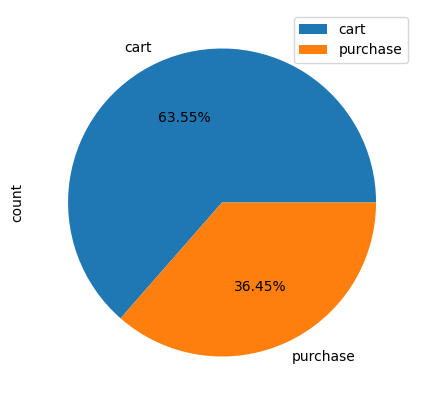

In [9]:
events = df.groupBy('event_type').count().toPandas()
events.plot(kind='pie', y='count', labels=events['event_type'], autopct='%1.2f%%', figsize=(5, 5))

In [10]:
## No. of different products
df.select(f.countDistinct("product_id")).show()

+--------------------------+
|count(DISTINCT product_id)|
+--------------------------+
|                    164453|
+--------------------------+



In [11]:
## No. of different users
df.select(f.countDistinct("user_id")).show()

+-----------------------+
|count(DISTINCT user_id)|
+-----------------------+
|                2547058|
+-----------------------+



In [12]:
## No. of distinct user sessions
df.select(f.countDistinct("user_session")).show()

+----------------------------+
|count(DISTINCT user_session)|
+----------------------------+
|                     7279439|
+----------------------------+



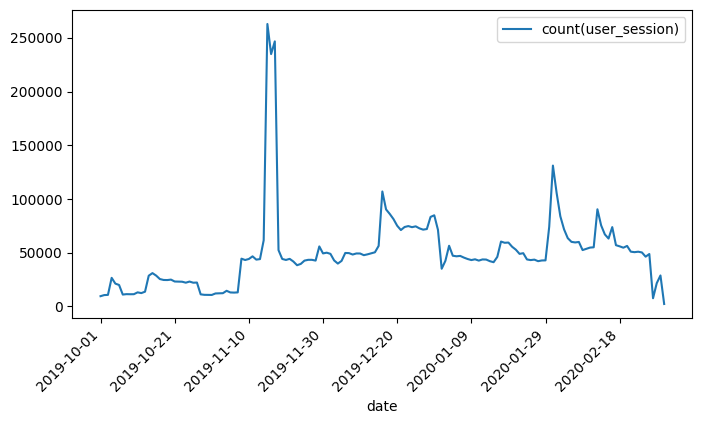

In [13]:
# Plot the daily number of sessions

df = df.withColumn('event_time', to_timestamp('event_time'))
df = df.withColumn('date', date_format("event_time", "yyyy-MM-dd"))

sessions = df.groupby('date').agg(countDistinct('user_session')).toPandas()
sessions.sort_values('date').plot(x='date', figsize=(8, 4))

# Adjust x-axis tick labels
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.show()

In [14]:
# Print the number of interactions between users and products, sorted by carts

interactions = df.groupby(['user_id', 'product_id']).agg(sum(when(df['event_type'] == 'cart', 1)).alias('carts'),                                                         
                                                         sum(when(df['event_type'] == 'purchase', 1)).alias('purchases'))

interactions.sort('carts', ascending=False).show()

+---------+----------+-----+---------+
|  user_id|product_id|carts|purchases|
+---------+----------+-----+---------+
|545442548|   1004767|  807|     null|
|525325337|   1004767|  753|     null|
|512875426|  15300303|  709|     null|
|515032042|   1004873|  489|        1|
|536911254|   4804718|  471|     null|
|557590749|   8800045|  380|     null|
|578263741|   3601537|  363|     null|
|611998200|   1005100|  333|     null|
|521558076|   1005008|  308|        1|
|553431815|   1005107|  296|      441|
|515481166| 100007950|  287|     null|
|513824664|   3601489|  275|     null|
|549621004|  28500010|  244|     null|
|515642515|  13101546|  237|     null|
|586742246| 100038635|  234|     null|
|583172291|   1005119|  233|     null|
|571683521|   1004870|  229|        1|
|520894168|   1004226|  227|     null|
|544355282|   4804055|  227|        1|
|594188870|   1005100|  214|     null|
+---------+----------+-----+---------+
only showing top 20 rows



In [15]:
df.groupby('product_id').agg(f.collect_set('cat_0'))\
                        .filter(size(col('collect_set(cat_0)')) == 1).count()

127060

In [16]:
## No. of product categories
df.select(f.countDistinct("cat_0")).show()

+---------------------+
|count(DISTINCT cat_0)|
+---------------------+
|                   14|
+---------------------+



In [17]:
df.filter((col('brand') != 'NA') & (col('cat_0') == 'NA') & (col('cat_1') == 'NA') & (col('cat_2') == 'NA') & (col('cat_3') == 'NA')).count()

1233350

In [18]:
df.filter((col('brand') == 'NA') & (col('cat_0') != 'NA')).count()

654744

### Data Preprocess

In [19]:
# Not run yet
def preprocess(df):
    
    # Change data types
    df = df.withColumn('event_time', to_timestamp('event_time'))
    df = df.withColumn('user_id', col('user_id').cast('integer'))
    df = df.withColumn('product_id', col('product_id').cast('integer'))

    # Discarding unwanted product categories
    df = df.filter(~col('cat_0').isin('construction', 'apparel', 'auto', 'medicine'))
    df = df.filter((col('brand') != 'NA') | (col('cat_0') != 'NA'))

    return df

df = preprocess(df)

In [20]:
# Filter rows where 'brand' is 'NA' and 'cat_0' is not 'NA'
R = df.filter((col('brand') == 'NA') & (col('cat_0') != 'NA'))

# Filter rows where both 'brand' and 'cat_0' are not 'NA'
S = df.filter((col('brand') != 'NA') & (col('cat_0') != 'NA'))

In [21]:
def count_matching_rows(R, distinct_values):
    count = 0
    for row in R.collect():
        if row['cat_0'] in distinct_values:
            count += 1
    return count

# Usage:
distinct_values = S.select(col('cat_0')).distinct().toPandas()['cat_0'].tolist()
matching_count = count_matching_rows(R, distinct_values)
print("Number of rows where R['cat_0'] matches distinct values:", matching_count)


Number of rows where R['cat_0'] matches distinct values: 395020


In [22]:
df.filter((col('brand') == 'NA') & (col('cat_0') != 'NA')).count()

395020

### Feature Engineering

In [23]:
# Partition dataframes for null and non-null values

# R is the dataframe where brand is unknown and product is known
R = df.filter((col('brand') == 'NA') & (col('cat_0') != 'NA'))

# S is the dataframe where brand is known and product is unknown
S = df.filter((col('brand') != 'NA') & (col('cat_0') == 'NA'))

# df_new is the dataframe where only non-null values of 'brand' and 'cat_0' are kept
df_new = df.filter((col('brand') != 'NA') & (col('cat_0') != 'NA'))
df_new = df_new.dropna(subset=['user_session'])

In [24]:
def add_category_code(df):
    # Create a new column 'category_code' by concatenating 'cat_0' and 'cat_1'
    df = df.withColumn('category_code', concat(col('cat_0'), lit(".") , col('cat_1')))
    return df

df_new = add_category_code(df_new)

In [25]:
def add_category_id(df):
    # Create a StringIndexer to generate category_id based on category_code
    indexer = StringIndexer(inputCol='category_code', outputCol='category_id', handleInvalid="keep")
    indexed_df = indexer.fit(df).transform(df)
    
    # Convert indexed values to integers
    indexed_df = indexed_df.withColumn('category_id', col('category_id').cast('integer'))
    
    return indexed_df

df_new = add_category_id(df_new)
df_new.show(5, truncate= False)

+-------------------+----------+----------+-------+------+---------+------------------------------------+------+-----------+----------+---------+-----+-------------------+-------+---------+----------+------+--------+-------+----------+----------------------+-----------+
|event_time         |event_type|product_id|brand  |price |user_id  |user_session                        |target|cat_0      |cat_1     |cat_2    |cat_3|timestamp          |ts_hour|ts_minute|ts_weekday|ts_day|ts_month|ts_year|date      |category_code         |category_id|
+-------------------+----------+----------+-------+------+---------+------------------------------------+------+-----------+----------+---------+-----+-------------------+-------+---------+----------+------+--------+-------+----------+----------------------+-----------+
|2019-11-01 05:30:14|cart      |1005014   |samsung|503.09|533326659|6b928be2-2bce-4640-8296-0efdf2fda22a|0     |electronics|smartphone|NA       |NA   |2019-11-01 05:30:14|0      |0       

In [26]:
def product_features(df):

    # Calculate several metrics for products with the aggregate function
    df = df.groupby('product_id').agg(first('category_id').alias('category_id'),
                                      first('category_code').alias('category_code'),
                                      count(when(df['event_type'] == 'cart', True)).alias('carts'),
                                      count(when(df['event_type'] == 'purchase', True)).alias('purchases'),
                                      mean('price').alias('price'),
                                      min('event_time').alias('first_date'),
                                      max('event_time').alias('last_date'))
    
    # Calculate interaction rates

    df = df.withColumn('purchase_per_cart', when(df['carts'] == 0, df['purchases']).otherwise(df['purchases'] / df['carts']))
    
    return df

In [27]:
def category_features(df):
    
    # Calculate the average product price for each category
    products = df.dropDuplicates(subset=['product_id'])
    products = products.groupby('category_id').agg(avg('price').alias('average_price'))

    # Calculate several metrics for categories with the aggregate function
    df = df.groupby('category_id').agg(first('category_code').alias('category_code'),
                                       countDistinct('product_id').alias('number_of_products'),
                                       count(when(df['event_type'] == 'cart', True)).alias('carts'),
                                       count(when(df['event_type'] == 'purchase', True)).alias('purchases'))
    
    # Calculate interaction rates
    df = df.withColumn('purchase_per_cart', when(df['carts'] == 0, df['purchases']).otherwise(df['purchases'] / df['carts']))
    
    df = df.join(products, on='category_id')
    
    return df

In [28]:
# Calculate smoothed rates for categories with small sample size using means of all products to combat overfitting
    
def category_smoothener(categories, mean, attr, rate, min_sample_size=1000):
    
    # Weighted average of category value and overall mean
    categories = categories.withColumn(rate, when(categories[attr] < min_sample_size, ((categories[rate] * categories[attr]) + (mean * (min_sample_size - categories[attr]))) / min_sample_size).otherwise(categories[rate]))
    
    return categories

In [29]:
# Calculate smoothed rates for products with small sample size using category means to combat overfitting
    
def product_smoothener(products, categories, attr, rate, min_sample_size=1000):
    
    category_rate = rate + '_cat'
    categories = categories.withColumnRenamed(rate, category_rate)
    products = products.join(categories['category_id', category_rate], on='category_id')
    
    # Weighted average of product value and category value
    products = products.withColumn(rate, when(products[attr] < min_sample_size, ((products[rate] * products[attr]) + (products[category_rate] * (min_sample_size - products[attr]))) / min_sample_size).otherwise(products[rate]))
    
    products = products.drop(category_rate)
    return products

In [30]:
# Calculate the price of each product relative to its category using the formula: (price - median) / IQR

def calculate_relative_price(products):
    
    categories = products.groupby('category_id').agg(percentile_approx('price', 0.25, 1000).alias('Q1'),
                                                     percentile_approx('price', 0.5, 1000).alias('median'),
                                                     percentile_approx('price', 0.75, 1000).alias('Q3'))
    # Interquartile range
    categories = categories.withColumn('IQR', col('Q3') - col('Q1'))
    categories = categories.withColumn('IQR', when(col('IQR') < 1, 1).otherwise(col('IQR')))
    
    # Calculate relative price
    products = products.join(categories, on='category_id')
    products = products.withColumn('relative_price', (col('price') - col('median')) / col('IQR'))
    
    # In order to avoid extreme values, set the max possible value to 5
    products = products.withColumn('relative_price', when(col('relative_price') > 5, 5).otherwise(col('relative_price')))

    # Set the min possible value to -5
    products = products.withColumn('relative_price', when(col('relative_price') < -5, -5).otherwise(col('relative_price')))

    products = products.select('product_id', 'relative_price')
    return products

In [31]:
# Extract product and category features

products = product_features(df_new)
categories = category_features(df_new)

In [32]:
# Calculate relative prices and append it to the main dataframe and product features

relative_prices = calculate_relative_price(products)

df_new = df_new.join(relative_prices, on='product_id')
products = products.join(relative_prices, on='product_id')

In [33]:
# Calculate the average interaction rates for all products to smooth category features with low interaction

avg_purchase_per_cart = events[events['event_type'] == 'purchase']['count'].values[0] / events[events['event_type'] == 'cart']['count'].values[0]

categories = category_smoothener(categories, avg_purchase_per_cart, 'carts', 'purchase_per_cart', 200)

In [34]:
# Smooth product features with low interaction using corresponding category features

products = product_smoothener(products, categories, 'carts', 'purchase_per_cart', 100)

In [35]:
def user_features(df):

    # Calculate several metrics for users with the aggregate function
    df = df.groupby('user_id').agg(count(when(df['event_type'] == 'cart', True)).alias('carts'),
                                   count(when(df['event_type'] == 'purchase', True)).alias('purchases'),
                                   countDistinct(when(df['event_type'] == 'cart', col('product_id'))).alias('distinct_products_carted'),
                                   countDistinct(when(df['event_type'] == 'purchase', col('product_id'))).alias('distinct_products_purchased'),
                                   mean(when(df['event_type'] == 'purchase', col('price'))).alias('average_price_purchased'),
                                   mean(when(df['event_type'] == 'purchase', col('relative_price'))).alias('avg_relative_price_purchased'),
                                   min('event_time').alias('first_date'),
                                   max('event_time').alias('last_date'))
    
    # Calculate interaction rates
    df = df.withColumn('purchase_per_cart', when(df['carts'] == 0, df['purchases']).otherwise(df['purchases'] / df['carts']))
    
    return df

In [36]:
# Extract user features

users = user_features(df_new)

In [37]:
# Top 50 products in terms of purchases

# products.sort('purchases', ascending=False).toPandas().head(50)
products.printSchema()

root
 |-- category_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_code: string (nullable = true)
 |-- carts: long (nullable = false)
 |-- purchases: long (nullable = false)
 |-- price: double (nullable = true)
 |-- first_date: timestamp (nullable = true)
 |-- last_date: timestamp (nullable = true)
 |-- purchase_per_cart: double (nullable = true)
 |-- relative_price: double (nullable = true)



In [38]:
# Convert timestamp columns to datetime
products = products.withColumn('first_date', col('first_date').cast('timestamp'))
products = products.withColumn('last_date', col('last_date').cast('timestamp'))

# Sort the DataFrame by 'purchases' column in descending order
top_50_products = products.orderBy(col('purchases').desc()).limit(50)

In [39]:
top_50_products.show()

+-----------+----------+--------------------+------+---------+------------------+-------------------+-------------------+-------------------+--------------------+
|category_id|product_id|       category_code| carts|purchases|             price|         first_date|          last_date|  purchase_per_cart|      relative_price|
+-----------+----------+--------------------+------+---------+------------------+-------------------+-------------------+-------------------+--------------------+
|          3|   4804056|   electronics.audio|140899|    84859|160.01074726036197|2019-10-01 05:41:00|2020-03-01 04:41:07| 0.6022682914711956|  0.5934102364379646|
|          0|   1004856|electronics.smart...| 60317|    51605| 128.6646537767211|2019-10-01 07:55:04|2019-12-01 05:26:03| 0.8555631082447734|-0.14939608158209594|
|          0|   1004767|electronics.smart...| 52117|    35654|247.27265964839307|2019-10-01 08:03:21|2019-12-01 05:28:57| 0.6841145883301034| 0.14876016104137865|
|          0|   100511

### Collaborative filtering

In [40]:
# Get the timestamp of the most recent event in the df
last_date = df_new.agg(max('event_time')).collect()[0][0]
df_new = df_new.withColumn('last_date', lit(last_date))

# Calculate the recency of each event in terms of days
df_new = df_new.withColumn('recency', (col('last_date').cast('double') - col('event_time').cast('double')) / 86400)
df_new = df_new.drop('last_date')

# Half-life decay function, the value of an event is halved after 20 days
df_new = df_new.withColumn('recency_coef', expr('exp(ln(0.5)*recency/20)'))

In [41]:
# Find the number of carts and purchases for each user-product pair
interactions = df_new.groupby(['user_id', 'product_id']).agg(sum(when(df_new['event_type'] == 'cart', 1) * df_new['recency_coef']).alias('carts'),
                                                         sum(when(df_new['event_type'] == 'purchase', 1) * df_new['recency_coef']).alias('purchases'))
interactions = interactions.na.fill(0)

In [42]:
def calculate_interaction_matrix(df, cart_weight=0.4, purchase_weight=1.0):
 
    # Create a new column with the weighted interaction value
    df = df.withColumn('interaction', cart_weight * col('carts') + purchase_weight * col('purchases'))
    
    # Use log10 value for views, carts and purchases
    df = df.withColumn('interaction', log10(col('interaction') + 1))
    
    # Set the max possible value to 100 (log100 = 2)
    df = df.withColumn('interaction', when(col('interaction') > 2, 2).otherwise(col('interaction')))

    return df

In [43]:
interaction_matrix = calculate_interaction_matrix(interactions)

In [44]:
#  User-product pairs with the highest interaction scores

interaction_matrix.sort('interaction', ascending=False).show()

+---------+----------+------------------+------------------+------------------+
|  user_id|product_id|             carts|         purchases|       interaction|
+---------+----------+------------------+------------------+------------------+
|563599039|   1005174| 5.216822607935234|138.34229840865544|               2.0|
|536911254|   4804718|392.30705812650694|               0.0|               2.0|
|559369947|   5100855|0.6001086863480617|61.881865855441106|1.8001801270665945|
|558033855|   4804055|3.0618951751249197| 56.11998001965234|1.7660016946290078|
|608008129|   4804718|130.84205010021222|               0.0|1.7270271193363844|
|598224683|   2702331|15.796491149497644| 45.02024458019186| 1.718824101652938|
|529011210|   1801881| 3.672617192786467|49.033805045417836| 1.711831278360134|
|605258231|  26500146|1.0615950453858758| 49.75146686234308|1.7090672277551255|
|557590749|   8800045|125.04464371221276|               0.0| 1.707722216288089|
|520947784|   2240125| 5.332844220571641

In [45]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

# def cross_validate_als(interaction_matrix):
    
#     # Define the ALS model
#     als = ALS(userCol='user_id', itemCol='product_id', ratingCol='interaction', 
#               nonnegative=True, coldStartStrategy='drop', implicitPrefs=True)

#     # Define the parameter grid for hyperparameter tuning
#     param_grid = ParamGridBuilder() \
#         .addGrid(als.rank, [5, 10, 15, 20]).addGrid(als.regParam, [0.005, 0.01, 0.05, 0.1]) \
#         .addGrid(als.alpha, [0, 1.0, 5.0]) \
#         .build()
        
#     # Define the evaluator for computing the evaluation metrics
#     evaluator = RegressionEvaluator(metricName='rmse', labelCol='interaction', predictionCol='prediction')

#     # Define the cross-validator for performing 5-fold cross-validation
#     cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5, collectSubModels=False)

#     # Define the pipeline for fitting the model and evaluating it
#     pipeline = Pipeline(stages=[cv])

#     # Fit the pipeline on the data and evaluate the model
#     model = pipeline.fit(interaction_matrix)
    
#     return model

In [46]:
# model = cross_validate_als(interaction_matrix)

# # Model with the lowest RMSE value 
# bestModel = model.stages[0].bestModel

# # Make predictions
# predictions = bestModel.transform(interaction_matrix)



In [47]:
# # Calculate RMSE and MAE metrics
# evaluator = RegressionEvaluator(metricName='rmse', labelCol='interaction', predictionCol='prediction')
# rmse = evaluator.setMetricName('rmse').evaluate(predictions)
# mae = evaluator.setMetricName('mae').evaluate(predictions)
# print(' rmse:' + str(rmse) + ' mae:' + str(mae))

# # Print the parameters of the model with the lowest RMSE value
# regParam = bestModel._java_obj.parent().getRegParam()
# rank = bestModel._java_obj.parent().getRank()
# alpha = bestModel._java_obj.parent().getAlpha()
# print('rank:' + str(rank) + ' regParam:' + str(regParam) + ' alpha:' + str(alpha))

In [48]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

def simple_als(interaction_matrix):
    
    # Train-test split
    (train, test) = interaction_matrix.randomSplit([0.8, 0.2])
    
    # Initialize the model with the optimized parameters
    als = ALS(userCol='user_id', itemCol='product_id', ratingCol='interaction', 
              alpha=5.0, regParam=0.1, rank=20, implicitPrefs=True, 
              nonnegative=True, coldStartStrategy='drop')

    # Fit the ALS model on the ratings data
    model = als.fit(train)
    
    # Make predictions
    predictions = model.transform(test)
    
    # Calculate the RMSE and MAE metrics
    evaluator = RegressionEvaluator(metricName='rmse', labelCol='interaction', predictionCol='prediction')
    rmse = evaluator.evaluate(predictions)
    mae = evaluator.setMetricName('mae').evaluate(predictions)
    print('test rmse:' + str(rmse) + ' mae:' + str(mae))
    
    return model

In [49]:
als_model = simple_als(interaction_matrix)

test rmse:0.11480117218877173 mae:0.06154526694486701


In [50]:
df_new.show(n=50, truncate=False)

+----------+-------------------+----------+---------+-------+---------+------------------------------------+------+-----------+-----------+-------+-----+-------------------+-------+---------+----------+------+--------+-------+----------+----------------------+-----------+---------------------+------------------+--------------------+
|product_id|event_time         |event_type|brand    |price  |user_id  |user_session                        |target|cat_0      |cat_1      |cat_2  |cat_3|timestamp          |ts_hour|ts_minute|ts_weekday|ts_day|ts_month|ts_year|date      |category_code         |category_id|relative_price       |recency           |recency_coef        |
+----------+-------------------+----------+---------+-------+---------+------------------------------------+------+-----------+-----------+-------+-----+-------------------+-------+---------+----------+------+--------+-------+----------+----------------------+-----------+---------------------+------------------+-----------------

### Recommend Products for Users

In [57]:
# 3 random users
user_subset = [559369947, 514673131, 512411198]

# Recommend top 500 products for the users
recommendations = sc.createDataFrame([(user, 0) for user in user_subset], ['user_id', 'product_id'])
recommendations = als_model.recommendForUserSubset(recommendations, 500)

In [58]:
recommendations.show()

Py4JJavaError: An error occurred while calling o968.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 823.0 failed 1 times, most recent failure: Lost task 1.0 in stage 823.0 (TID 1395) (10.184.16.101 executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:192)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:166)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:101)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1623)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:694)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:738)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:690)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:655)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:631)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:588)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:546)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:179)
	... 32 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2785)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2721)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2720)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2720)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1206)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2984)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2912)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:192)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:166)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:101)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1623)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:694)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:738)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:690)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:655)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:631)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:588)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:546)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:179)
	... 32 more


In [54]:
# Select user 514673131
recs_for_user_1 = sc.createDataFrame(recommendations.collect()[1][1])

Py4JJavaError: An error occurred while calling o906.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 771.0 failed 1 times, most recent failure: Lost task 0.0 in stage 771.0 (TID 1350) (10.184.16.101 executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:192)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:166)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:101)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1623)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:694)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:738)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:690)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:655)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:631)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:588)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:546)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:179)
	... 32 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2785)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2721)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2720)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2720)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1206)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2984)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2912)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:192)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:166)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:101)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1623)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:694)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:738)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:690)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:655)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:631)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:588)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:546)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:179)
	... 32 more


In [ ]:
# Products with the highest number of interactions for the user

interactions.filter(col('user_id') == 516454226).sort('purchases', ascending=False).show()

In [ ]:
def calculate_recommendation_scores_for_user(user_id, recs, products, users, coef_als_score=0.8, coef_conversion_rate=0.1, coef_spending_habit=0.1, coef_spending_booster=0.05):
   
    recs = recs.join(products['product_id', 'purchase_per_view', 'relative_price'], on='product_id')
    
    user_avg_relative_price = users.filter(col('user_id') == user_id)['user_id', 'avg_relative_price_purchased'].collect()[0][1]

    
    # Scale CF rating score, ranges from 0 to 2
    recs = recs.withColumn('rating', col('rating') / 2)
    
    # Scale purchase_per_view rate, ranges from 0 to 0.075
    recs = recs.withColumn('purchase_per_view', col('purchase_per_view') / 0.075)
    
    # Scale relative price value, ranges from -5 to 5
    recs = recs.withColumn('relative_price', (col('relative_price') + 5) / 10)
    
    # Scale users average relative price value, ranges from -1 to 1
    user_avg_relative_price = (user_avg_relative_price + 1) / 2
    
    
    # Calculate the recommendation scores
    recs = recs.withColumn('recommendation_score', ((recs['rating'] * coef_als_score) + (recs['purchase_per_view'] * coef_conversion_rate) - abs(user_avg_relative_price + coef_spending_booster - recs['relative_price']) * coef_spending_habit) / (coef_als_score + coef_conversion_rate + coef_spending_habit)) 

    
    # Scale back CF rating score, ranges from 0 to 2
    recs = recs.withColumn('rating', col('rating') * 2)

    # Scale back purchase_per_view rate, ranges from 0 to 0.075
    recs = recs.withColumn('purchase_per_view', col('purchase_per_view') * 0.075)
    
    # Scale back relative price value, ranges from -1 to 1
    recs = recs.withColumn('relative_price', col('relative_price') * 2 - 1)

    # Scale back average relative price value, ranges from -5 to 5
    user_avg_relative_price = user_avg_relative_price * 10 - 5
    
    return recs

In [ ]:
recs_user = calculate_recommendation_scores_for_user(564068124, recs_for_user_1, products, users)

In [ ]:
# Products with the highest recommendation scores

recs_user.sort('recommendation_score', ascending=False).show()

In [ ]:
# Filter non-interacted products in recommendations using left-anti join
non_interacted_products = recs_user.join(interactions.filter(col('user_id') == 564068124), on='product_id', how='leftanti')

# Non-interacted products with the highest recommendation scores
non_interacted_products.sort('recommendation_score', ascending=False).show()

### Recommend Products for Products

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer
from pyspark.ml.feature import SQLTransformer

# Get the product factors from the ALS model
product_vectors = best_model.itemFactors
product_vectors = product_vectors.rdd.map(lambda row: (row[0], Vectors.dense(row[1])))
product_vectors = product_vectors.toDF(['product_id', 'features'])

# Use VectorAssembler to convert the features column into a dense vector column
assembler = VectorAssembler(inputCols=['features'], outputCol='vector')
product_vectors = assembler.transform(product_vectors)

# Normalize the vectors
normalizer = Normalizer(inputCol='vector', outputCol='norm_vector')
product_vectors = normalizer.transform(product_vectors)

# Get the normalized vector representation of the selected product
product_vector = product_vectors.where(col('product_id') == 5100067).select('norm_vector').collect()[0][0]
product_vector